In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import requests 

from fiona.crs import from_epsg

### At the individual level -- Integrated Public Use Microdata Samples

In [3]:
ipums = pd.read_csv("data/ipums_2018.csv.bz2", 
                    usecols = ["YEAR", "SAMPLE", "PERWT", "HHWT", 
                               "STATEFIP", "COUNTYFIP", "METRO", "MET2013", "CITY",
                               "PUMA", "GQ", "HHINCOME", "CILAPTOP", "CISMRTPHN", "CITABLET", "CIHAND", 
                               "CINETHH", "CIDATAPLN", "CIHISPEED", "CISAT", "CIDIAL", "CIOTHSVC", 
                               "SEX", "AGE", "RACE", "HISPAN", "RACBLK", "RACWHT", "EDUC", 
                               "INCTOT", "FTOTINC", "INCWAGE", "INCEARN", "POVERTY"])

In [4]:
ipums["C"] = 1
ipums["BA"] = ipums["EDUC"] >= 10
ipums["logFInc"] = np.log(ipums["FTOTINC"])
ipums["logInc"] = np.log(ipums["INCTOT"])
ipums["isGQ"] = ipums.GQ > 2

ipums["sex"]  = np.where(ipums.SEX == 1,      "Male", "Female")
ipums["blk"]  = np.where(ipums.RACBLK == 2,   "Black", "Non-Black")
ipums["hisp"] = np.where(ipums.HISPAN > 0,    "Hispanic", "Non-Hispanic")
ipums["wht"]  = np.where(ipums.RACWHT == 2,   "White", "Non-White")
ipums["pov"]  = np.where(ipums.POVERTY < 100, "Below Poverty Line", "Above Poverty Line")

ipums["any_access"]  = ipums.CINETHH.isin([1, 2]).astype(int)
ipums["broadband"] = ipums.CIHISPEED.isin(range(10, 20)).astype(int)
ipums["data_plan"] = (ipums.CIDATAPLN == 1).astype(int)
ipums["satellite"] = (ipums.CISAT == 1).astype(int)

ipums["laptop"] = ipums.CILAPTOP == 1
ipums["smartphone"] = ipums.CISMRTPHN == 1

ipums.rename(columns = {"STATEFIP" : "STATE", "COUNTYFIP" : "COUNTY"}, inplace = True)

/home/jsaxon/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/jsaxon/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
/home/jsaxon/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/home/jsaxon/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log


### Cities don't work, so use CBSAs.

In [5]:
cbsa = ["new_york", "los_angeles", "chicago", "dallas-fort_worth", "houston", 
        "philadelphia", "washington", "miami", "atlanta", "boston", 
        "san_francisco", "riverside", "phoenix", "detroit", "seattle", 
        "minneapolis", "san_diego", "tampa", "st_louis", "baltimore"]

cbsa_dict = {
    35620 : "new_york", 31080 : "los_angeles", 16980 : "chicago", 19100 : "dallas-fort_worth", 26420 : "houston", 
    37980 : "philadelphia", 47900 : "washington", 33100 : "miami", 12060 : "atlanta", 14460 : "boston", 
    41860 : "san_francisco", 40140 : "riverside", 38060 : "phoenix", 19820 : "detroit", 42660 : "seattle", 
    33460 : "minneapolis", 41740 : "san_diego", 45300 : "tampa", 41180 : "st_louis", 12580 : "baltimore"
}

ipums.query("(MET2013 in @cbsa_dict) & (GQ in [1, 2])", inplace = True)
ipums["cbsa"] = ipums.MET2013.replace(cbsa_dict)

In [6]:
def h_weighted_mean(grp): return grp._get_numeric_data().multiply(grp['HHWT'], axis=0).sum()/grp['HHWT'].sum()
def p_weighted_mean(grp): return grp._get_numeric_data().multiply(grp['PERWT'], axis=0).sum()/grp['PERWT'].sum()

In [21]:
agg = ipums.groupby("cbsa").apply(h_weighted_mean)\
           [["any_access", "broadband", "data_plan", "laptop", "smartphone"]].round(3)
    
agg = agg.reindex(cbsa)
agg.index = agg.index.str.replace("_", " ").str.title()
agg# .sort_values("broadband", ascending = False)

,any_access,broadband,data_plan,laptop,smartphone
cbsa,,,,,
New York,0.920,0.788,0.826,0.841,0.900
Los Angeles,0.932,0.760,0.840,0.844,0.927
Chicago,0.929,0.778,0.838,0.839,0.913
Dallas-Fort Worth,0.927,0.746,0.853,0.820,0.936
Houston,0.922,0.738,0.838,0.801,0.923
Philadelphia,0.932,0.819,0.848,0.842,0.899
Washington,0.957,0.849,0.883,0.898,0.937
Miami,0.907,0.746,0.770,0.836,0.921
Atlanta,0.936,0.787,0.852,0.863,0.932


In [19]:
divide = []
for v, label, low, high in [["sex",  "Gender",    "Female", "Male"],
                            ["blk",  "Race",      "Black", "Non-Black"],
                            ["hisp", "Ethnicity", "Hispanic", "Non-Hispanic"],
                            ["pov",  "Poverty",   "Below Poverty Line", "Above Poverty Line"]]:
    
    X = ipums.groupby(["cbsa", v]).apply(p_weighted_mean).broadband.unstack()
    X["Δ" + label] = X[high] - X[low]
    divide.append(X)


divide = pd.concat(divide, axis = 1).round(3)
# divide = divide.filter(regex = "Δ", axis = 1)

divide.index = divide.index.str.replace("_", " ").str.title()
divide.sort_values(by = "ΔRace", ascending = False)

,Female,Male,ΔGender,Black,Non-Black,ΔRace,Hispanic,Non-Hispanic,ΔEthnicity,Above Poverty Line,Below Poverty Line,ΔPoverty
cbsa,,,,,,,,,,,,
Detroit,0.752,0.763,0.012,0.597,0.807,0.210,0.729,0.759,0.030,0.795,0.536,0.258
St Louis,0.746,0.759,0.013,0.620,0.785,0.165,0.687,0.754,0.068,0.777,0.569,0.208
Chicago,0.771,0.783,0.012,0.660,0.802,0.142,0.697,0.801,0.104,0.799,0.596,0.203
Baltimore,0.780,0.790,0.010,0.689,0.829,0.140,0.662,0.793,0.131,0.813,0.538,0.275
Philadelphia,0.810,0.823,0.012,0.722,0.844,0.122,0.727,0.826,0.099,0.840,0.649,0.190
Seattle,0.850,0.849,-0.001,0.738,0.859,0.121,0.751,0.860,0.110,0.866,0.672,0.194
Boston,0.846,0.855,0.009,0.754,0.861,0.108,0.750,0.864,0.113,0.866,0.694,0.172
Miami,0.740,0.746,0.006,0.666,0.765,0.099,0.722,0.761,0.039,0.767,0.589,0.179
Tampa,0.786,0.792,0.006,0.704,0.802,0.098,0.715,0.807,0.093,0.816,0.610,0.206


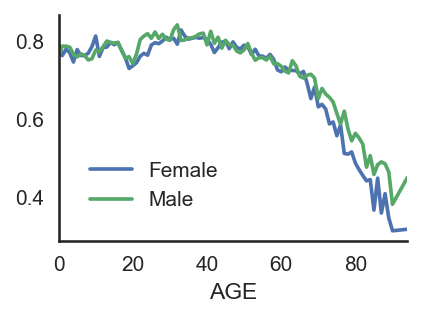

In [29]:
fig, ax = plt.subplots(figsize = (3, 2))

ipums[~ipums.isGQ].groupby(["AGE", "sex"]).broadband.mean().unstack().plot(ax = ax)

ax.get_legend().set_title("")

### Cities

* https://usa.ipums.org/usa-action/variables/CITY#codes_section
* Starting from Houston (and then San Antonio, San Diego, Dallas, San Jose, etc.), they're irregularly available 

In [24]:
cities = ["new_york", "los_angeles", "chicago", "houston", "phoenix",
          "philadelphia", "san_antonio", "san_diego", "dallas",
          "san_jose", "austin", "jacksonville", "san_francisco", "columbus",
          "fort_worth", "indianapolis", "charlotte", "seattle", "denver", "washington"]

city_dict = {4610 : "new_york", 3730 : "los_angeles",  1190 : "chicago",     2890 : "houston", 5350 : "phoenix",  
             5330 : "philadelphia", 6230 : "san_antonio", 6270 : "san_diego", 1590 : "dallas", 6310 : "san_jose",
              490 : "austin", 3110 : "jacksonville", 6290 : "san_francisco", 1450 : "columbus", 2350 : "fort_worth",
             2990 : "indianapolis", 1090 : "charlotte", 6430 : "seattle", 1710 : "denver", 7230 : "washington"}